In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# Convolution Neural Networks 

합성곱 신경망 

이미지 인식, 음성 인식 등에 사용됨 


# 7.1 전체 구조

* Pooling Layer 추가됨 

* Fully Connected (전결합) : 인접하는 계층의 모든 뉴런과 결합

* Affine 계층 : 완전히 연결된 계층 

        Affine -> ReLU -> Affine -> ReLU -> Affine -> Softmax ->

* CNN 구조 
    
        Conv -> ReLU -> Pooling -> Conv -> ReLU -> Pooling
        -> Conv -> ReLU -> Affine -> ReLU -> Affine -> Softmax -> 
    
    Conv 합성곱 계층과 Pooling 계층이 추가 됨 

    

# 7.2 Conv 계층

## 7.2.1 Fully Connected 계층의 문제점 

* Fully Connected : 인접하는 계층의 뉴런이 모두 연결되고 출력의 수는 임의로 정할 수 있다. 

    문제점 : 데이터의 형상이 무시 된다. <br>
    예) 3차원 이미지 데이터를 평평한 1차원 데이터로 바꿔서 연산을 해야함 MNIST 데이터 셋을 사용한 사례에서 (1,28,28) 이미지를 1줄로 784 개의 데이터를 Affine 계층에 입력으로 사용


* Feature map : 합성곱 계층의 입출력 데이터 
    input feature map, output feature map
    
    
## 7.2.2 Conv 연산

합성곱 연산은 이미지 처리에서 말하는 **필터 연산** 에 해당

가로 세로 방향의 차원을 가짐 입력 (4,4) 필터는 (3,3) -> (2,2) 출력 

<img src='CNNFilter.png' width=50%>

* kernel : 필터 

* window : 합성곱의 연산은 필터의 윈도우를 일정간격으로 이동하며 입력데이터 적용 

입력과 필터에서 대응하는 원소끼리 곱한 후 그 총합을 구함 (단일곱셈 누산 Fused multiply-add FMA 라함) 그 결과를 출력의 장소에 저장 

CNN 에서의 필터 = 가중치 

편향은 항상 하나만 존재하여 필터를 적용한 모든 원소에 같은 값을 더하여 사용 


## 7.2.3 패딩

* padding : 입력 데이터 주변의 특정 값을 채움 

-- 패딩은 주로 출력 크기를 조정할 목적으로 사용, 입력 데이터의 공간적 크기를 고정한 채로 다음 계층에 전달 할수 있다. (Conv 연산을 거칠때 마다 점점 크기가 줄어듬을 방지) 


## 7.2.4 스트라이드 

* stride : 필터를 적용하는 위치의 간격, window 가 이동하는 간격 (보폭)

입력 (H,W) 필터 (FH, FW) -> 출력 (OH, OW) <br>
패딩 P, 스트라이드 S

\begin{equation*}
    OH = \frac{H + 2P + - FH}{S} + 1 \\
    OW = \frac{H + 2P + - FW}{S} + 1
\end{equation*}

정수로 나눠 떨어져야함. 값이 딱 나눠 떨어지지 않을 때엔 가장 가까운 정수로 반올림 등 (특별히 에러를 내지 않고 진행하도록 구현)

## 7.2.5 3차원 데이터의 Conv 연산 

http://cs231n.github.io/convolutional-networks/

필터도 여러가지 채널(색상) 에 맞춰서 줘야한다. 채널이 3개면 필터도 3개 

## 7.2.6 블록으로 생각하기 

3차원의 연산은 데이터와 필터를 직육면체 블록으로 생각 

채널수 C, 필터 높이 FH, 필터 너비 FW (C, FH, FW)

<img src='CNNblock.png' width=50%/>


여러개의 필터를 사용하면 4차원이 됨 -> 출력데이터가 필터의 개수만큼 만들어짐 (FN)

형상이 다른 블록의 덧셈은 브로드캐스트됨


## 7.2.7 배치 처리 

<img src ='CNNblock2.png' width=50%/>

블럭이 N 개, 필터의 개수는 그대로 (N 데이터수, FN 필터 수 , OH 높이, OW 너비) 4차원의 데이터 

N 개의 데이터에 대한 합성곱 연산이 이뤄짐 



# 7.3 풀링계층 

Pooling layer : 가로, 세로 방향의 공간을 줄이는 연산 


* 최대 풀링(max pooling)을 스트라이드 2로 처리 영역의 최대값을 취함 
* 평균 풀링 : 평균 풀링은 대상 영역의 평균으로 계산 

## 7.3.1 풀링계층의 특징

* 최댓값 혹은 평균을 취하는 명확한 처리하므로 학습해야 할 매개변수가 없다.
* 채널마다 독립적으로 계산하므로 채널 수가 변하지 않는다.
* 입력 데이터가 조금 변해도 풀링의 결과는 잘 변하지 않는다. (영향을 적게 받는다, 떨림 같은..)


# 7.4 합성곱/풀링 계층 구현하기

## 7.4.1 4차원배열

* 높이 28, 너비 28, 채널 1 인 이미지 데이터 10개 (10, 1, 28, 28)


In [8]:
import numpy as np
x = np.random.rand(10, 1, 28, 28)
x.shape
x[0].shape
x[0, 0][:2]

(10, 1, 28, 28)

(1, 28, 28)

array([[ 0.63464697,  0.29145329,  0.70943543,  0.07292147,  0.61769742,
         0.0262977 ,  0.63931379,  0.88161805,  0.50876108,  0.96345767,
         0.30438957,  0.47415976,  0.89437433,  0.42327603,  0.70335345,
         0.53635078,  0.83545286,  0.12923368,  0.90939233,  0.40892987,
         0.3615447 ,  0.70294223,  0.58095422,  0.47800973,  0.84101858,
         0.92739338,  0.94328139,  0.68488791],
       [ 0.09005096,  0.38282588,  0.6024875 ,  0.79704861,  0.71563762,
         0.42587486,  0.50756603,  0.49538155,  0.57475933,  0.51511513,
         0.58623892,  0.81419385,  0.89426036,  0.5061551 ,  0.18958154,
         0.10657779,  0.18733242,  0.10495775,  0.52886277,  0.217858  ,
         0.93185952,  0.19957075,  0.07862927,  0.65470483,  0.12457137,
         0.59053177,  0.01442056,  0.34501623]])

## 7.4.2 im2col 로 데이터 펼침

넘파이에서는 원소에 접근할 때 for 문을 사용하지 않는 것이 좋음

<img src = 'CNNim2col.png' width=50%>
* im2col 함수를 구현 : 입력데이터를 필터링(가중치 계산) 하기 좋게 전개하는(펼치는)함수, 4차원 데이터가 2차원 행렬로 바뀜 
    <br>입력데이터에서 필터를 적용해 3차원 블록을 한줄로 늘어 놓음 
    
* caffe 와 chainer 에서도 im2col 이용 

<img src ='CNNim2col1.png' width=50%>

필터를 세로로 1열로 전개 N 개의 필터 만큼 [데이터열 x FN] 이 됨 <br>
2차원인 출력 데이터를 4차원의 reshape 함


In [9]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns 
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [11]:
x1 = np.random.rand(1,3,7,7) # 데이터 수, 채널, 높이, 너비 (4차원데이터)
col1 = im2col(x1, 5, 5,stride=1, pad=0)
col1.shape # 9 출력 이미지의 사이즈 75/3=25 채널 3 개로 되어 있음 1채널에는 25 = 5개 씩 5개 

(9, 75)

In [12]:
x2 = np.random.rand(10,3,7,7) 
col2 = im2col(x2, 5, 5,stride=1, pad=0)
col2.shape

(90, 75)

In [14]:
x1[:, :,:5, :5]

array([[[[ 0.49151141,  0.12164675,  0.86855103,  0.22889157,  0.14627692],
         [ 0.07541529,  0.3949526 ,  0.33361449,  0.86657293,  0.4811581 ],
         [ 0.32640807,  0.39474257,  0.82698389,  0.73426756,  0.2800613 ],
         [ 0.07286197,  0.3153743 ,  0.3133537 ,  0.87511364,  0.28247084],
         [ 0.42991487,  0.09583869,  0.14669056,  0.30303999,  0.64246304]],

        [[ 0.05630697,  0.65717021,  0.79114124,  0.45824106,  0.034449  ],
         [ 0.61192191,  0.39725512,  0.64123497,  0.75642833,  0.05970315],
         [ 0.01500802,  0.33153892,  0.80708351,  0.68613629,  0.50918153],
         [ 0.03102622,  0.61155163,  0.56794188,  0.11420271,  0.15683787],
         [ 0.12565463,  0.09268063,  0.37644713,  0.55595962,  0.53431739]],

        [[ 0.84796216,  0.07615896,  0.20359564,  0.84968551,  0.69550601],
         [ 0.49095945,  0.34566338,  0.28857688,  0.38606163,  0.02631764],
         [ 0.88426045,  0.25525849,  0.790754  ,  0.69487079,  0.05823669],
        

In [13]:
col1[0, :] #  0.05630697 6번째 -> x1 의 두번쨰 [[ 0.05630697 합쳐짐

array([ 0.49151141,  0.12164675,  0.86855103,  0.22889157,  0.14627692,
        0.07541529,  0.3949526 ,  0.33361449,  0.86657293,  0.4811581 ,
        0.32640807,  0.39474257,  0.82698389,  0.73426756,  0.2800613 ,
        0.07286197,  0.3153743 ,  0.3133537 ,  0.87511364,  0.28247084,
        0.42991487,  0.09583869,  0.14669056,  0.30303999,  0.64246304,
        0.05630697,  0.65717021,  0.79114124,  0.45824106,  0.034449  ,
        0.61192191,  0.39725512,  0.64123497,  0.75642833,  0.05970315,
        0.01500802,  0.33153892,  0.80708351,  0.68613629,  0.50918153,
        0.03102622,  0.61155163,  0.56794188,  0.11420271,  0.15683787,
        0.12565463,  0.09268063,  0.37644713,  0.55595962,  0.53431739,
        0.84796216,  0.07615896,  0.20359564,  0.84968551,  0.69550601,
        0.49095945,  0.34566338,  0.28857688,  0.38606163,  0.02631764,
        0.88426045,  0.25525849,  0.790754  ,  0.69487079,  0.05823669,
        0.56016581,  0.67255286,  0.09210888,  0.43415972,  0.63

## 7.4.3 합성곱 계층 구현

- Pooling 클래스
    - forward() 메소드
        - 입력 데이터 전개
        - 행별 최댓값
        - 적절한 모향으로 성형
    - backward() 메소드
        - ReLU 노드 구현 시 사용한 max의 역전파 참고

In [35]:
import sys, os
sys.path.append(os.pardir)
from common.util import col2im

In [ ]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape  # 필터개수, 채널, 필터높이, 필터폭
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        ## Conv 구현 
        col = im2col(x, FH, FW, self.stride, self.pad)
        # 2차원 배열로 만듬 
        col_W = self.W.reshape(FN, -1).T
        # 두 행렬의 내적함 
        out = np.dot(col, col_W) + self.b
        
        # (N,H,W,C) -> (N, C, H, W) 로 변경함 
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    # col2im 컬럼을 이미지로 변환하는 함수 사용 
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

In [26]:
# numpy reshape
x = np.array(np.arange(27)).reshape(1,3,3,3)
x
x.reshape(1,-1)

array([[[[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8]],

        [[ 9, 10, 11],
         [12, 13, 14],
         [15, 16, 17]],

        [[18, 19, 20],
         [21, 22, 23],
         [24, 25, 26]]]])

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]])

In [34]:
x1 = np.array(np.arange(8)).reshape(4,2)
x1
x1.reshape(1,2,2,-1)
x1.reshape(1,2,2,-1).transpose(0, 3, 1, 2) #0,2,4.. 열을 2x2 행렬 데이터로 바꿈 

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7]])

array([[[[0, 1],
         [2, 3]],

        [[4, 5],
         [6, 7]]]])

array([[[[0, 2],
         [4, 6]],

        [[1, 3],
         [5, 7]]]])

## 7.4.4 풀링 계층 구현

im2col 함수를 사용해 입력 데이터 전개

채널이 독립인 점이 합성곱 계층과 다른 점 (채널별로 다 구함)

* 풀링 계층 구현의 흐름: 최대 풀링(가장 큰 원소는 회색으로 표시)
    - 입력 데이터 전개
    - 행별 최댓값
    - 적절한 모향으로 성형

<img src='CNNmaxPooling.png' width=50%>

** 풀링 계층 구현하기 **

* Pooling 클래스
    - forward() 메소드
        - 입력 데이터 전개
        - 행별 최댓값 (np.max(x, axis=1) x 의 1번째 차원의 축마나 최댓값을 구함 
        - 적절한 모향으로 성형
    - backward() 메소드
        - ReLU 노드 구현 시 사용한 max의 역전파 참고

In [36]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        # 전개 
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        # 최댓값 
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        # reshape
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


# 7.5 CNN 구현하기

layer 마다 활성화 함수를 사용하는 이유 : Affine (FC) 모든 노드가 다음 모든노드에 연결되어 있을때 이전 노드의 출력이 0 이 되는 것을 방지함 

<img src='CNNM.png' width=50%>

    """단순한 합성곱 신경망
    
     [W1]  conv - relu - pool - [W2] - affine - relu - [W3] - affine - softmax
    
    Parameters
    ----------
    filter_num : 필터수 
    filter_size : 필터 크기
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """


In [42]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:

    # 28x28 정사각형
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        # output 도 정사각형 출력 크기 계산 
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        # filter -> Conv
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        # poll out -> hiddent input(Affine)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        # hidden out -> output input
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        # W1
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        # W2
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        # W3
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        
        # forward : 계층의 앞부터 계산 결과를 다음 계층에 전달 
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]


In [43]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from tmp.dataset.mnist import load_mnist
#from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()


train loss:2.3004933729
=== epoch:1, train acc:0.225, test acc:0.283 ===
train loss:2.29759204223
train loss:2.29630255832
train loss:2.28675761048
train loss:2.28628841839
train loss:2.27836895007
train loss:2.26065546549
train loss:2.25340627217
train loss:2.24488923317
train loss:2.20976790229
train loss:2.18030040008
train loss:2.16575824722
train loss:2.15049411198
train loss:2.08104603623
train loss:2.03276491604
train loss:1.98379224527
train loss:1.95328003997
train loss:1.81915474906
train loss:1.81567198019
train loss:1.75879464667
train loss:1.62372378823
train loss:1.57343644673
train loss:1.5160620078
train loss:1.53236897986
train loss:1.29320807595
train loss:1.23867080235
train loss:1.1878332515
train loss:1.06468662389
train loss:1.02382487568
train loss:0.993899497916
train loss:0.895273827021
train loss:0.979171921067
train loss:0.877360956926
train loss:0.89361443878
train loss:0.857050385868
train loss:0.807713651045
train loss:0.820289636544
train loss:0.692833462

train loss:0.138045493214
train loss:0.12691529553
train loss:0.258115171816
train loss:0.15861901814
train loss:0.155343196257
train loss:0.294687538856
train loss:0.160332996816
train loss:0.168511754807
train loss:0.211770083785
train loss:0.271274921992
train loss:0.196312279583
train loss:0.126804571389
train loss:0.199524577309
train loss:0.160117859818
train loss:0.144780357701
train loss:0.124910259614
train loss:0.196337186277
train loss:0.353179704404
train loss:0.096237289156
train loss:0.168967874172
train loss:0.0976045323448
train loss:0.330319634179
train loss:0.269093141621
train loss:0.0753767099363
train loss:0.144696869609
train loss:0.258841901554
train loss:0.235106617488
train loss:0.117319018108
train loss:0.128988061647
train loss:0.272467165287
train loss:0.1820315636
train loss:0.192307905237
train loss:0.168116807677
train loss:0.174215389251
train loss:0.123384829383
train loss:0.146144821958
train loss:0.173533722348
train loss:0.109101595976
train loss:0.1

train loss:0.0966513169651
train loss:0.107132341746
train loss:0.101334615624
train loss:0.232162452183
train loss:0.073205624353
train loss:0.0987732374247
train loss:0.0696021063618
train loss:0.154184723147
train loss:0.0429455570664
train loss:0.0975227185958
train loss:0.0472816530465
train loss:0.0523910580187
train loss:0.0664572954407
train loss:0.150672444096
train loss:0.0636971721359
train loss:0.101014758119
train loss:0.191071997139
train loss:0.059638459658
train loss:0.161911347342
train loss:0.1226293994
train loss:0.2216275944
train loss:0.132167947643
train loss:0.0993279988694
train loss:0.0424454051398
train loss:0.0987157555444
train loss:0.0891415706367
train loss:0.100274814935
train loss:0.120874238816
train loss:0.123216213597
train loss:0.128377607318
train loss:0.0793404770287
train loss:0.0642617436143
train loss:0.0704460946985
train loss:0.109823997964
train loss:0.0526296806596
train loss:0.0879606911657
train loss:0.116918542715
train loss:0.09198719912

train loss:0.086662345017
train loss:0.0383415839786
train loss:0.130283875151
train loss:0.0314460857308
train loss:0.0544416475956
train loss:0.106301049837
train loss:0.0732475329261
train loss:0.0534056486528
train loss:0.0440004273862
train loss:0.0677768463097
train loss:0.0478028674061
train loss:0.141632558268
train loss:0.0350227159192
train loss:0.0242941076585
train loss:0.0556026693248
train loss:0.0133629592659
train loss:0.0319497697418
train loss:0.0788925465566
train loss:0.116892756662
train loss:0.135615447853
train loss:0.148619549408
train loss:0.0668209686477
train loss:0.0522488648812
train loss:0.0555230662634
train loss:0.053710627426
train loss:0.0815354983249
train loss:0.0142247998696
train loss:0.0367602926152
train loss:0.0798551914678
train loss:0.0876333922547
train loss:0.140060359466
train loss:0.0511424398368
train loss:0.0776431332295
train loss:0.0926996693191
train loss:0.0845359921443
train loss:0.0741222937669
train loss:0.0702679192843
train loss

train loss:0.0140677587736
train loss:0.0760943040871
train loss:0.0487974484743
train loss:0.0597810507037
train loss:0.09728968058
train loss:0.0517319021428
train loss:0.0684254577032
train loss:0.0545469225661
train loss:0.119548434254
train loss:0.0202668798776
train loss:0.0644620055555
train loss:0.0862493028834
train loss:0.0684785480934
train loss:0.102831802485
train loss:0.0117449407398
train loss:0.0464538188131
train loss:0.0821749560939
train loss:0.0372859593596
train loss:0.0545827873177
train loss:0.058310393084
train loss:0.0551884464758
train loss:0.0785567200748
train loss:0.162321365475
train loss:0.0248299076235
train loss:0.0389826287061
train loss:0.013833249521
train loss:0.0304857437051
train loss:0.0592724980379
train loss:0.106435105177
train loss:0.0434927154563
train loss:0.0990108182521
train loss:0.0192271075766
train loss:0.0814568687369
train loss:0.0454799366509
train loss:0.0561210780638
train loss:0.00995306753627
train loss:0.0185533299172
train lo

train loss:0.0343452096321
train loss:0.0440036172914
train loss:0.022106051105
train loss:0.0329651883124
train loss:0.0498363731325
train loss:0.0184092652535
train loss:0.0920491021498
train loss:0.0165490390516
train loss:0.0337501613278
train loss:0.0600713212468
train loss:0.0399745283849
train loss:0.141202977895
train loss:0.0656496910617
train loss:0.0235124529538
train loss:0.0726269249678
train loss:0.0503749119081
train loss:0.0172851408455
train loss:0.0421797396638
train loss:0.0680954088583
train loss:0.0142427950391
train loss:0.0233726779828
train loss:0.0313417728458
train loss:0.0378387693086
train loss:0.0787935753059
train loss:0.0543035110276
train loss:0.0491907453612
train loss:0.0258536705645
train loss:0.105512493279
train loss:0.0251191900988
train loss:0.0282350860091
train loss:0.0521257228342
train loss:0.0427811991649
train loss:0.0105840732892
train loss:0.0349138291142
train loss:0.084189399538
train loss:0.0332336397303
train loss:0.0630240348054
train

train loss:0.0137715459766
train loss:0.0292482620668
train loss:0.021634852762
train loss:0.0842644883661
train loss:0.0424439948741
train loss:0.0100771672929
train loss:0.0432995904589
train loss:0.0195773663655
train loss:0.0229951703242
train loss:0.0504503946427
train loss:0.0589089433845
train loss:0.105693582712
train loss:0.0810127943574
train loss:0.0315701251771
train loss:0.0275058050266
train loss:0.0177734895255
train loss:0.0318631103369
train loss:0.022294038805
train loss:0.0309698070659
train loss:0.0215887719609
train loss:0.0253929074688
train loss:0.0656142239684
train loss:0.0160056747989
train loss:0.00809246418951
train loss:0.0164223617266
train loss:0.0402638973523
train loss:0.0193890427915
train loss:0.0592562050812
train loss:0.029883169379
train loss:0.0746581953444
train loss:0.020298808358
train loss:0.0696484021136
train loss:0.031930728359
train loss:0.0297411669672
train loss:0.0321766783786
train loss:0.0261608252801
train loss:0.0385648853084
train 

train loss:0.0190614349927
train loss:0.0146276885645
train loss:0.0200485095175
train loss:0.0453989199729
train loss:0.0612668712753
train loss:0.0367015963311
train loss:0.0209499453042
train loss:0.00398383888214
train loss:0.023628487439
train loss:0.00797132918317
train loss:0.0551049232191
train loss:0.0206915059756
train loss:0.0809736990281
train loss:0.0422975261159
train loss:0.0307946220416
train loss:0.0387549710213
train loss:0.00950422144219
train loss:0.0181681593363
train loss:0.00637134731401
train loss:0.0105789362672
train loss:0.0457737925451
train loss:0.0470970914443
train loss:0.0222450081071
train loss:0.0120911797869
train loss:0.0703469421367
train loss:0.0135589724376
train loss:0.0274095361972
train loss:0.0211667029481
train loss:0.0342895570279
train loss:0.0442736415407
train loss:0.00987335484977
train loss:0.012485236636
train loss:0.0294288012712
train loss:0.0377617024862
train loss:0.0341159257404
train loss:0.0090991958371
train loss:0.020804233851

train loss:0.0209537653284
train loss:0.0173092369398
train loss:0.0479228808906
train loss:0.0146668766919
train loss:0.00550514215284
train loss:0.0517347594398
train loss:0.00741237438378
train loss:0.0747071725385
train loss:0.0342447294999
train loss:0.0377906682759
train loss:0.0124464056287
train loss:0.021462626042
train loss:0.0183527415541
train loss:0.0122977920976
train loss:0.125540944342
train loss:0.04145985742
train loss:0.0101457898708
train loss:0.0193655943042
train loss:0.0228192188466
train loss:0.0237873845837
train loss:0.100688221326
train loss:0.00557456930024
train loss:0.0152500771525
train loss:0.0110907947129
train loss:0.0246676293157
train loss:0.0153798772105
train loss:0.0132855720162
train loss:0.0268906330041
train loss:0.032182885049
train loss:0.0598358131134
train loss:0.0288850152262
train loss:0.0210474182273
train loss:0.0397481786969
train loss:0.00959883210166
train loss:0.132701620189
train loss:0.156581571384
train loss:0.0917081145095
train

train loss:0.0440065146526
train loss:0.10826125075
train loss:0.0331018740698
train loss:0.00963159578001
train loss:0.031209029907
train loss:0.0204206783478
train loss:0.0287883959555
train loss:0.0242074954043
train loss:0.0328989426266
train loss:0.0169814451281
train loss:0.0131340225675
train loss:0.028786760702
train loss:0.0139760375109
train loss:0.034150201669
train loss:0.0163009652764
train loss:0.00358652178404
train loss:0.0175405855794
train loss:0.00808945048128
train loss:0.00502564538783
train loss:0.0174663107259
train loss:0.02400232999
train loss:0.0209120183777
train loss:0.0119855667629
train loss:0.0174195021458
train loss:0.0514145735249
train loss:0.0163447202187
train loss:0.102022671617
train loss:0.0397236872335
train loss:0.0387485460677
train loss:0.0365722580931
train loss:0.00947222107493
train loss:0.0105406731708
train loss:0.0109274496643
train loss:0.0108424752704
train loss:0.00834323906386
train loss:0.00487980331556
train loss:0.0270197266417
tr

train loss:0.0544623131766
train loss:0.00369689687477
train loss:0.00976804715688
train loss:0.00189490555817
train loss:0.0105580836338
train loss:0.00670897646617
train loss:0.0111524597726
train loss:0.00219520009096
train loss:0.0130223848194
train loss:0.00118603150672
train loss:0.0139551178753
train loss:0.0295014495897
train loss:0.0457505322905
train loss:0.0158996939613
train loss:0.0203518404868
train loss:0.00356739148578
train loss:0.00780200613025
train loss:0.0602697849631
train loss:0.0352915447563
train loss:0.00542580927329
train loss:0.0325748064379
train loss:0.0285584571706
train loss:0.0370130359264
train loss:0.00972040188661
train loss:0.043426038625
train loss:0.00672445954341
train loss:0.0148163722373
train loss:0.122277500321
train loss:0.0404223612423
train loss:0.0225665597004
train loss:0.0079230905836
train loss:0.0156084484602
train loss:0.0160614885578
train loss:0.0570722081184
train loss:0.0275227198214
train loss:0.0503551331289
train loss:0.011176

train loss:0.0583097901588
train loss:0.0477981175302
train loss:0.00993401001799
train loss:0.0216286950774
train loss:0.0222990395304
train loss:0.00899865603543
train loss:0.00890011664681
train loss:0.00900541574931
train loss:0.0176842587641
train loss:0.0884982101644
train loss:0.00675264399752
train loss:0.027074253628
train loss:0.00395942787666
train loss:0.0430532391962
train loss:0.0150547206935
train loss:0.0185314654023
train loss:0.0297560570227
train loss:0.0487779085398
train loss:0.0335913875079
train loss:0.00790575828011
train loss:0.0586742803094
train loss:0.0529410028485
train loss:0.00995865269727
train loss:0.0122452420215
train loss:0.0259620561067
train loss:0.0232696253492
train loss:0.0312888369198
train loss:0.00689899246725
train loss:0.0255126761363
train loss:0.00643197082698
train loss:0.00940745107772
train loss:0.0155403160375
train loss:0.035673851055
train loss:0.0259390100056
train loss:0.0141008481579
train loss:0.00728441573569
train loss:0.03100

train loss:0.0223536867858
train loss:0.0113816608612
train loss:0.00974326679514
train loss:0.0016284054372
train loss:0.0126128134103
train loss:0.00466583658592
train loss:0.0172658332418
train loss:0.00168526189497
train loss:0.00464488152807
train loss:0.0236976600113
train loss:0.0172645995578
train loss:0.00315756446707
train loss:0.016708485563
train loss:0.0413528552085
train loss:0.0201466834384
train loss:0.0164885538541
train loss:0.00978435239774
train loss:0.0175147018501
train loss:0.00786671237974
train loss:0.0204843569305
train loss:0.00853011199973
train loss:0.00236281398767
train loss:0.020739469484
train loss:0.0126398786117
train loss:0.00510341044575
train loss:0.00540477721689
train loss:0.00176249292661
train loss:0.00818071397922
train loss:0.0103888581341
train loss:0.00626346125359
train loss:0.0123068993218
train loss:0.0109250393884
train loss:0.0135415798068
train loss:0.00649910265257
train loss:0.00234559767599
train loss:0.00706347263523
train loss:0.

train loss:0.0186054512638
train loss:0.011627659195
train loss:0.0313951052772
train loss:0.0100317229116
train loss:0.00395172425491
train loss:0.00810656937736
train loss:0.00696786520276
train loss:0.0758451997783
train loss:0.0111667884541
train loss:0.0227047805991
train loss:0.0433036940394
train loss:0.016488639337
train loss:0.0251268510712
train loss:0.0131581803378
train loss:0.0113583984112
train loss:0.00539697833218
train loss:0.0156739727762
train loss:0.010156632401
train loss:0.0283745110589
train loss:0.0121219398384
train loss:0.0128531100148
train loss:0.0164745174582
train loss:0.0055544255687
train loss:0.0219563565871
train loss:0.0202810135863
train loss:0.00427994567799
train loss:0.00165163725912
train loss:0.00219185529591
train loss:0.00731790131541
train loss:0.00765503824274
train loss:0.0200485405312
train loss:0.0188326330161
train loss:0.0064331945219
train loss:0.0721557159759
train loss:0.00716887719506
train loss:0.0206775431227
train loss:0.00953807

train loss:0.00778857992803
train loss:0.0026447748689
train loss:0.0277583086055
train loss:0.0119110806104
train loss:0.0126570295778
train loss:0.0113676322535
train loss:0.0158103842217
train loss:0.00812664631183
train loss:0.0149548701672
train loss:0.00322050584688
train loss:0.0274053129499
train loss:0.00341873720039
train loss:0.0227114188315
train loss:0.0127136646815
train loss:0.00580430449533
train loss:0.0104978479456
train loss:0.00350014916493
train loss:0.00622127899131
train loss:0.0155590707843
train loss:0.0518331590871
train loss:0.00177700116727
train loss:0.0098683868546
train loss:0.0025189036247
train loss:0.0194320394044
train loss:0.00616988955731
train loss:0.023142079508
train loss:0.0600285432866
train loss:0.0185505341787
train loss:0.00403018088255
train loss:0.00833108109876
train loss:0.0142277470665
train loss:0.00428410398153
train loss:0.00399085407651
train loss:0.00361252631891
train loss:0.0156932897399
train loss:0.00566400125829
train loss:0.0

train loss:0.00182510165248
train loss:0.00380891928314
train loss:0.00446180420022
train loss:0.00130873367405
train loss:0.0148316754948
train loss:0.00385574752798
train loss:0.0429927597541
train loss:0.00495173106664
train loss:0.00844337242647
train loss:0.00672040122116
train loss:0.0152432679196
train loss:0.0107481240203
train loss:0.00362228610371
train loss:0.00983588325352
train loss:0.00161527503071
train loss:0.00384121348593
train loss:0.0182143604262
train loss:0.0215573705143
train loss:0.00560713213144
train loss:0.00381940776058
train loss:0.00873882908349
train loss:0.0127537420709
train loss:0.0380904136718
train loss:0.00488080899139
train loss:0.0113275490968
train loss:0.00224604029867
train loss:0.00562308242819
train loss:0.00180909750807
train loss:0.0316873991031
train loss:0.0489543667315
train loss:0.0130573431068
train loss:0.00113676126138
train loss:0.0152765955256
train loss:0.0145769210814
train loss:0.0148824108378
train loss:0.000929074216508
train 

train loss:0.00413985390569
train loss:0.0350226100171
train loss:0.0170755945682
train loss:0.00564066062723
train loss:0.00455065523294
train loss:0.0161491013935
train loss:0.0059603137711
train loss:0.0164127851656
train loss:0.00845215091826
train loss:0.0174548558197
train loss:0.0138623360702
train loss:0.0236379001764
train loss:0.00838944985872
train loss:0.011997256632
train loss:0.026954091247
train loss:0.00440182162056
train loss:0.00538236722091
train loss:0.0176166790576
train loss:0.0436568429325
train loss:0.0054041800685
train loss:0.0320307491197
train loss:0.00950474786281
train loss:0.00470707934701
train loss:0.0124466661262
train loss:0.00740362924595
train loss:0.00331102773157
train loss:0.0141787870381
train loss:0.00473551085175
train loss:0.00165267081527
train loss:0.0100687226505
train loss:0.00925973021154
train loss:0.00688857857451
train loss:0.00533910580359
train loss:0.00118259488687
train loss:0.0148104229466
train loss:0.00315805658034
train loss:0

train loss:0.00475413126991
train loss:0.00392799923746
train loss:0.0364496297933
train loss:0.0063714957709
train loss:0.0297958751744
train loss:0.0319232900721
train loss:0.0711886117673
train loss:0.00324261119539
train loss:0.0283709018818
train loss:0.0260506156208
train loss:0.00236224695194
train loss:0.00338236113997
train loss:0.00770102264574
train loss:0.0140275051092
train loss:0.00712507193863
train loss:0.0101836265306
train loss:0.0131686499954
train loss:0.00622679618881
train loss:0.0383199904966
train loss:0.0142242384046
train loss:0.0141880796184
train loss:0.0157552407297
train loss:0.0137452835717
train loss:0.00398875906522
train loss:0.00515560692294
train loss:0.0176553795534
train loss:0.0136614511831
train loss:0.00403787845391
train loss:0.0127801037884
train loss:0.00324813278434
train loss:0.00387205134706
train loss:0.0234435603135
train loss:0.0127137570005
train loss:0.00259209129376
train loss:0.00442849781646
train loss:0.0295461046964
train loss:0.

train loss:0.0254409816561
train loss:0.00208698256571
train loss:0.00693295323293
train loss:0.0148272959115
train loss:0.0275652352209
train loss:0.0023696059513
train loss:0.00111311304512
train loss:0.0142347563885
train loss:0.00230806769478
train loss:0.0244070650807
train loss:0.0128698287739
train loss:0.0202454003846
train loss:0.0236938116236
train loss:0.000898156115483
train loss:0.00775200731693
train loss:0.000946890559541
train loss:0.0193694883558
train loss:0.00888892631115
train loss:0.0100484199114
train loss:0.0189202075707
train loss:0.0027737167784
train loss:0.00189361333483
train loss:0.0255242892289
train loss:0.00459131809085
train loss:0.0058845825686
train loss:0.00487712125695
train loss:0.000722243962318
train loss:0.00265141962765
train loss:0.00272997436569
train loss:0.00924600614459
train loss:0.00342667142467
train loss:0.00880531586256
train loss:0.00270734631593
train loss:0.0559945301683
train loss:0.00675049520587
train loss:0.00230935872583
train

train loss:0.000670387146331
train loss:0.0436640485303
train loss:0.0237402851291
train loss:0.00498038282085
train loss:0.00581534400294
train loss:0.00991912929158
train loss:0.00264596728788
train loss:0.0161643803871
train loss:0.00365322114355
train loss:0.00229209576574
train loss:0.00360219637941
train loss:0.013846262941
train loss:0.0155172108362
train loss:0.00175585805903
train loss:0.0032921147869
train loss:0.00424210551809
train loss:0.00844156276478
train loss:0.0441907831427
train loss:0.0165507607265
train loss:0.0118585588363
train loss:0.0107369721147
train loss:0.00205922119293
train loss:0.0261308892914
train loss:0.00278064074651
train loss:0.00102547442833
train loss:0.0118825198266
train loss:0.0141507462433
train loss:0.0192200967801
train loss:0.00675000632229
train loss:0.000656053698002
train loss:0.00260022592669
train loss:0.00190099931031
train loss:0.00117777750244
train loss:0.00258522924828
train loss:0.00847078350959
train loss:0.00692800615785
train

train loss:0.00565802361654
train loss:0.00480165559518
train loss:0.00561217283114
train loss:0.0031056170452
train loss:0.00173592895876
train loss:0.00354325126883
train loss:0.00496662586196
train loss:0.00275316982024
train loss:0.0106411247077
train loss:0.00493940701969
train loss:0.0115116793444
train loss:0.0054100943956
train loss:0.0100963236404
train loss:0.00968242852673
train loss:0.00564846463216
train loss:0.00852190000572
train loss:0.000973001856058
train loss:0.00145115672008
train loss:0.0058571038034
train loss:0.00109071150506
train loss:0.00266559826513
train loss:0.00210829012052
train loss:0.00129499083754
train loss:0.0109318193464
train loss:0.00502198194529
train loss:0.000835910705183
train loss:0.00279463066752
train loss:0.00666278086227
train loss:0.00310561085824
train loss:0.00551343162678
train loss:0.00236828861228
train loss:0.0085106438188
train loss:0.00371818579708
train loss:0.000745313368215
train loss:0.0116967737466
train loss:0.0005594212405

train loss:0.00830121477094
train loss:0.00192870346748
train loss:0.00163605927568
train loss:0.00958249625598
train loss:0.027995300291
train loss:0.00438949523563
train loss:0.00452653691974
train loss:0.00345441500521
train loss:0.00587826190398
train loss:0.0023950561928
train loss:0.00202884994021
train loss:0.00170554428312
train loss:0.00107019126781
train loss:0.00601081049426
train loss:0.00372514731873
train loss:0.00747035420939
train loss:0.00214050996081
train loss:0.00252577929752
train loss:0.00320229945837
train loss:0.00354627439699
train loss:0.00338309631461
train loss:0.0788688831763
train loss:0.0335872156189
train loss:0.00579377075365
train loss:0.0124367425971
train loss:0.00134474747558
train loss:0.00605790134348
train loss:0.0103985295605
train loss:0.00605705828774
train loss:0.00225713106747
train loss:0.00353964947575
train loss:0.00277136749912
train loss:0.00572847388672
train loss:0.00274327665278
train loss:0.0332808814061
train loss:0.00798802156582


train loss:0.00770744904563
train loss:0.00199695832779
train loss:0.00757403625011
train loss:0.00227526372337
train loss:0.00273063262613
train loss:0.000558568107109
train loss:0.00339520492522
train loss:0.0033725452548
train loss:0.0210272467233
train loss:0.00427296157659
train loss:0.00736226301868
train loss:0.00083204615924
train loss:0.000891752450736
train loss:0.000413085182932
train loss:0.00404341728456
train loss:0.018969484841
train loss:0.00542501118367
train loss:0.00197189684246
train loss:0.00216956186518
train loss:0.00833732478816
train loss:0.00405257008879
train loss:0.00181821587329
train loss:0.0243710119819
train loss:0.0014944769381
train loss:0.0023488756047
train loss:0.00149464914713
train loss:0.000847859026549
train loss:0.00771256456777
train loss:0.00196369611129
train loss:0.00986468481855
train loss:0.00167726882798
train loss:0.102261266067
train loss:0.0163236065982
train loss:0.00127065217779
train loss:0.000150139747294
train loss:0.008016247794

train loss:0.000842020960029
train loss:0.0191563689945
train loss:0.0101011669873
train loss:0.00082419795288
train loss:0.000724839432722
train loss:0.00270221794306
train loss:0.0035183152227
train loss:0.00709490392574
train loss:0.00109003841167
train loss:0.00536040064665
train loss:0.000763920260604
train loss:0.00500860444546
train loss:0.0132457039038
train loss:0.0108341899397
train loss:0.00342338455712
train loss:0.00344439517359
train loss:0.00337470098992
train loss:0.0150159882391
train loss:0.002698968957
train loss:0.0168917650571
train loss:0.000750105332324
train loss:0.00287154407095
train loss:0.00555240040694
train loss:0.0136560105505
train loss:0.00385726902262
train loss:0.00980625811834
train loss:0.00959244241645
train loss:0.0207020292287
train loss:0.012859226316
train loss:0.00102994805899
train loss:0.000224769654157
train loss:0.000972912697933
train loss:0.000951225149733
train loss:0.00234817301768
train loss:0.0009621099651
train loss:0.00355546995447

train loss:0.00226403155558
train loss:0.000765750080449
train loss:0.000571410812994
train loss:0.016644560475
train loss:0.00109278960165
train loss:0.00722810064002
train loss:0.00331325332061
train loss:0.00465411633941
train loss:0.00282681315865
train loss:0.0116606036653
train loss:0.00617718672403
train loss:0.00774324381833
train loss:0.00689958141449
train loss:0.00615205109407
train loss:0.0100254319532
train loss:0.000355593106839
train loss:0.0115358559251
train loss:0.00381497519275
train loss:0.00232403307365
train loss:0.000438057015157
train loss:0.000419577532351
train loss:0.0110958274557
train loss:0.00534477717664
train loss:0.0042779690955
train loss:0.00037959657463
train loss:0.000259357560484
train loss:0.00114816426946
train loss:0.00498981388727
train loss:0.00631994581882
train loss:0.00875164198356
train loss:0.00344271105332
train loss:0.000989748097594
train loss:0.000415938077981
train loss:0.00133227401744
train loss:0.00781568899735
train loss:0.003275

train loss:0.00035904867492
train loss:0.000284942025832
train loss:0.00165032495544
train loss:0.00203649481143
train loss:0.00381291097102
train loss:0.00859206209563
train loss:0.000419138439238
train loss:0.000565616095179
train loss:0.00447293418757
train loss:0.00194061100234
train loss:0.00977853896177
train loss:0.00243573627278
train loss:0.00295837660901
train loss:0.00174261786673
train loss:0.000690738445908
train loss:0.00661291728211
train loss:0.00257084893409
train loss:9.09518935464e-05
train loss:0.000256266819169
train loss:0.00175716187892
train loss:0.00691512729768
train loss:0.00131465333698
train loss:0.000605328574144
train loss:0.00151795853842
train loss:0.00112366595948
train loss:0.00151086546079
train loss:0.00523709171003
train loss:0.00185168800775
train loss:0.000218976686181
train loss:0.0111145424355
train loss:0.000780046971333
train loss:0.000935589104533
train loss:0.00187790324992
train loss:0.0124956682207
train loss:0.00107759795847
train loss:0

train loss:0.000934939386806
train loss:0.000142930755195
train loss:0.000477706647145
train loss:0.000684224028426
train loss:0.000561744640581
train loss:0.0224326813187
train loss:0.00408142295906
train loss:0.00188341651141
train loss:0.00560763117906
train loss:0.0091123361889
train loss:0.00138836652643
train loss:0.0226290676059
train loss:0.00088786487413
train loss:0.00129578406077
train loss:0.00195588336007
train loss:0.0107010509917
train loss:0.00185928419839
train loss:0.0022747514654
train loss:0.00789012124513
train loss:0.00633283262375
train loss:0.00226968359382
train loss:0.017002918613
train loss:0.00376240819464
train loss:0.00452485749616
train loss:0.00187058915678
train loss:0.00461323558362
train loss:0.00662370486657
train loss:0.00270147336966
train loss:0.00779516647458
train loss:0.0111886997895
train loss:0.0109605128482
train loss:0.000852003631915
train loss:0.0159634035211
train loss:0.00134137311014
train loss:0.0038688110931
train loss:0.002524296679

train loss:0.00110621894356
train loss:0.00748291554373
train loss:0.00234786603626
train loss:0.0111323193201
train loss:0.00492488169346
train loss:0.00302574903114
train loss:0.00312606784212
train loss:0.00160149526016
train loss:0.00261238454102
train loss:0.000233290822072
train loss:0.00382584295586
train loss:0.00236598259571
train loss:0.00081318351838
train loss:0.00381649496528
train loss:0.00483789760571
train loss:0.00232167292047
train loss:0.024713959008
train loss:0.00823000604175
train loss:0.00115917328895
train loss:0.000559193021658
train loss:0.00723631120796
train loss:0.00190834099165
train loss:0.00246382004609
train loss:0.0023251950587
train loss:0.000840479910468
train loss:0.00354147114174
train loss:0.00111871854924
train loss:0.00479562645123
train loss:0.000618752263209
train loss:0.00345903496262
train loss:0.0100871416796
train loss:0.00129697448986
train loss:0.00601165829987
train loss:0.00204863497803
train loss:0.00500086079892
train loss:0.00391160

train loss:0.00911641865128
train loss:0.00188402070662
train loss:0.00321398618515
train loss:0.0012463337166
train loss:0.00619007988006
train loss:0.0061503376011
train loss:0.00278806327294
train loss:0.00327466965518
train loss:0.0032036824793
=== epoch:15, train acc:0.997, test acc:0.987 ===
train loss:0.00312691166344
train loss:0.00156165526814
train loss:0.00304461333292
train loss:0.00747790062106
train loss:0.00811053433069
train loss:0.00233024319713
train loss:0.000542410165994
train loss:0.00984798036207
train loss:0.000576400610232
train loss:0.00102167003619
train loss:0.000946036025841
train loss:0.00886840480994
train loss:0.000582227725173
train loss:0.00908491537093
train loss:0.00358933757528
train loss:0.00243208168679
train loss:0.00547259253578
train loss:0.00338902353828
train loss:0.0133204294062
train loss:0.000159848609565
train loss:0.00679256891044
train loss:0.00348946999111
train loss:0.00313295335682
train loss:0.000872760052383
train loss:0.00040683333

train loss:0.00439769855482
train loss:0.00124314244317
train loss:0.00207647017593
train loss:0.000764091797855
train loss:0.00178912480652
train loss:0.00132593143494
train loss:0.00352254491864
train loss:0.00857587760185
train loss:0.000255363740966
train loss:0.0038884176105
train loss:0.000822815530903
train loss:0.0040904062471
train loss:0.00306784773991
train loss:0.000926760807159
train loss:0.00330624816542
train loss:0.00220477987749
train loss:0.00229100698447
train loss:0.00419198032897
train loss:0.00143573046198
train loss:0.00680930851402
train loss:0.00440915044068
train loss:0.00210993868362
train loss:0.00295799004529
train loss:0.00208841881306
train loss:0.000533232565287
train loss:0.000909071789139
train loss:0.00141546133287
train loss:0.00141746146773
train loss:0.000280491620623
train loss:0.0269756189728
train loss:0.00245684759
train loss:0.000635982337184
train loss:0.00109307810198
train loss:0.00308804252443
train loss:0.00798304288446
train loss:0.00079

train loss:0.00243176400479
train loss:0.00113534932697
train loss:0.00680833126752
train loss:0.00121128052253
train loss:0.000329309223978
train loss:0.000158303097435
train loss:0.00119457196289
train loss:0.00256333652179
train loss:0.000206779432115
train loss:0.000274039274224
train loss:0.000114494592696
train loss:0.00029286202424
train loss:0.00234728175055
train loss:0.00088895363329
train loss:0.00875227345652
train loss:0.00311193061476
train loss:0.00522068972487
train loss:0.022940069544
train loss:0.00186920433324
train loss:0.00873314462418
train loss:0.00917487156949
train loss:0.000454873292957
train loss:0.0139187765709
train loss:0.0085502893519
train loss:0.0140301117186
train loss:0.00530604014138
=== epoch:16, train acc:0.998, test acc:0.986 ===
train loss:0.00967264213789
train loss:0.00298642158216
train loss:0.000793866007833
train loss:0.00209844066258
train loss:0.00472963026977
train loss:0.00586199787178
train loss:0.00340246520942
train loss:0.00983719294

train loss:0.000206805119497
train loss:0.00699273316196
train loss:0.000148325549303
train loss:0.0168985385016
train loss:0.00136067112465
train loss:0.00383426547813
train loss:0.00126652123055
train loss:0.00100537487503
train loss:0.000973726106432
train loss:0.00284246078726
train loss:0.00252286266623
train loss:0.00106603944358
train loss:0.00227730590676
train loss:0.003783292575
train loss:0.000568071428166
train loss:0.00167301130908
train loss:0.000520807620297
train loss:0.0024879954285
train loss:0.00193565529408
train loss:0.00019949851286
train loss:0.000798796699663
train loss:0.000485890203228
train loss:0.0019375699623
train loss:0.0018067604337
train loss:0.00127604334478
train loss:0.00407997842499
train loss:0.000713848411534
train loss:0.000516586098723
train loss:0.00202319309732
train loss:0.000202678861089
train loss:0.000694072089679
train loss:0.00424139166151
train loss:0.00221520415489
train loss:0.00296013518226
train loss:0.00355237871164
train loss:0.00

train loss:0.0124712938651
train loss:0.0021007318023
train loss:0.000500595199986
train loss:0.000160141237618
train loss:0.00104697734666
train loss:0.00154244989602
train loss:0.00090967305932
train loss:0.000743221838088
train loss:0.00257489695964
train loss:0.000734229415478
train loss:0.000387505365829
train loss:0.000121880355716
train loss:0.00097398085135
train loss:0.00418422703995
train loss:0.0143429347038
train loss:0.000604783841605
train loss:0.00204387427125
train loss:0.00266598173402
train loss:0.000334212020339
train loss:0.000415174579689
train loss:0.00186023434816
train loss:0.00155555747621
train loss:0.00270803481247
train loss:0.000452598430822
train loss:0.000497284816196
train loss:0.0174888609094
train loss:0.00107509752144
train loss:0.000684394999823
train loss:0.00136108943215
train loss:0.00044029531569
train loss:0.000410934328208
train loss:0.00366390699563
train loss:0.0117208591555
train loss:0.00464839842524
train loss:0.000626937620692
train loss:

train loss:0.00601466396897
train loss:0.00115229794309
train loss:0.0025719452577
train loss:0.00353206841319
train loss:0.000722616235079
train loss:0.0276671691621
train loss:0.00260730931953
train loss:0.00802671832124
train loss:0.00743378921534
train loss:0.000634981678646
train loss:0.00107753505443
train loss:0.0102614950928
train loss:0.000609821569412
train loss:0.000404743651116
train loss:0.00407510067969
train loss:0.00326828712214
train loss:0.000122275974412
train loss:0.00278297940603
train loss:0.000689650011959
train loss:0.00324893606924
train loss:0.0106082514406
train loss:0.00224853804524
train loss:0.00382225337942
train loss:0.00136620219607
train loss:0.00261485795566
train loss:0.00149799980644
train loss:0.00098749570692
train loss:0.00563716059245
train loss:0.00377084043966
train loss:0.000682797452777
train loss:0.00700288843847
train loss:0.00212774725834
train loss:0.00497717183377
train loss:0.00157761248071
train loss:0.000571339825014
train loss:0.001

train loss:0.000822310333758
train loss:0.00182839941232
train loss:0.000329651573431
train loss:0.010780510405
train loss:0.00665846458214
train loss:0.000154399742217
train loss:0.00164243739956
train loss:0.00632448788672
train loss:0.00230114284916
train loss:0.00101366362014
train loss:0.00174269851462
train loss:0.0026756899399
train loss:0.00188740152859
train loss:0.000459038132424
train loss:0.00407453058577
train loss:0.00148857461677
train loss:0.0309405822122
train loss:0.000353528612461
train loss:0.0050729623868
train loss:0.00146673114285
train loss:0.00318255272378
train loss:0.00321667414438
train loss:0.00723374270783
train loss:0.000429356164892
train loss:0.000763986943179
train loss:0.000519367709636
train loss:0.0116576547449
train loss:0.00514165916345
train loss:0.00126085737689
train loss:0.000442668457096
train loss:0.000380438089686
train loss:0.00427803559228
train loss:0.00185755404966
train loss:0.000110649044543
train loss:0.00263492346169
train loss:0.00

train loss:0.0017666862537
train loss:0.000365555378518
train loss:0.000465187714375
train loss:0.000265669974512
train loss:0.00303029204178
train loss:0.000943739233809
train loss:0.00023782299974
train loss:0.00114581485659
train loss:0.00353559818152
train loss:0.000165674958285
train loss:0.0013359615838
train loss:0.00118321827214
train loss:0.000138749939026
train loss:0.000266357627698
train loss:0.00201148782835
train loss:0.000414474416773
train loss:0.000412761184057
train loss:0.000819995464367
train loss:0.00693155124537
train loss:3.17538701768e-05
train loss:0.000652090080721
train loss:0.00157880201901
train loss:0.00268861012445
train loss:0.000681766117014
train loss:0.000922914344731
train loss:0.0011101899474
train loss:0.0244626543338
train loss:0.000808954682263
train loss:0.00417671295519
train loss:0.000840809902415
train loss:6.99484108329e-05
train loss:0.00318474055787
train loss:0.0731627770054
train loss:0.000472547054912
train loss:0.000184009143639
train 

train loss:0.000126711764384
train loss:0.00310730518634
train loss:0.00130181014133
train loss:0.000435376611512
train loss:0.000497436342086
train loss:0.000822458698994
train loss:9.05437500043e-05
train loss:0.00184816844978
train loss:1.88024584922e-05
train loss:0.00010433689095
train loss:0.000142953995805
train loss:0.0130178636599
train loss:4.61889563683e-05
train loss:0.000722003255153
train loss:0.000739820967428
train loss:0.000301848379138
train loss:0.00216147571054
train loss:0.000749704694066
train loss:0.000323739580469
train loss:0.00409492227773
train loss:0.00179280190875
train loss:0.000590330925864
train loss:0.000207160050488
train loss:0.00248826599815
train loss:0.000394045583893
train loss:0.000107468437925
train loss:0.00146980257004
train loss:0.000852393492298
train loss:0.00311842540861
train loss:0.000131188775683
train loss:0.00140371291359
train loss:0.00126531404658
train loss:0.00228084512226
train loss:0.00119085048472
train loss:0.001946992543
trai

train loss:0.000649563564819
train loss:0.000686328632239
train loss:0.000476418872709
train loss:0.00113691585795
train loss:0.000978995048031
train loss:0.000424052339988
train loss:0.000453661941731
train loss:0.000135433665132
train loss:0.00211800903881
train loss:0.000149663302632
train loss:0.000794775854204
train loss:0.0102851567575
train loss:0.000626402228584
train loss:0.0102540345638
train loss:0.000748648018776
train loss:0.00121412450415
train loss:0.00134720297384
train loss:0.000213584264092
train loss:0.000925283179509
train loss:0.000523808556648
train loss:0.000685490783052
train loss:0.000369240150611
train loss:0.00636202277915
train loss:0.00116784008911
train loss:0.000835662676105
train loss:7.67300454368e-05
train loss:0.00440415234061
train loss:0.00183062893216
train loss:0.00025067427559
train loss:0.00158735492265
train loss:0.00537968471527
train loss:0.000655889633181
train loss:0.0238871226109
train loss:0.000399911099912
train loss:0.000422265435746
tr

train loss:0.0127499737009
train loss:0.00020916986497
train loss:0.00653381826325
train loss:0.00771248025517
train loss:0.00893676871016
train loss:0.000348804414027
train loss:5.43836925042e-05
train loss:0.0014116657867
train loss:0.00347637005712
train loss:0.000577025141867
train loss:9.65632492955e-05
train loss:7.54930722999e-06
train loss:6.76511511377e-05
train loss:9.1208752383e-05
train loss:6.22482417254e-05
train loss:0.00131331742471
train loss:0.00115140218268
train loss:0.00190885413311
train loss:0.000581750512249
train loss:0.00140737243671
train loss:0.00299638232384
train loss:0.000259677995983
train loss:0.000408615271697
train loss:0.000531711300539
train loss:0.00038911846041
train loss:0.000193443079195
train loss:0.000526624695782
train loss:0.000143833864416
train loss:0.000721370117259
train loss:0.00167389911719
train loss:0.0010075282272
train loss:5.68934762863e-05
train loss:7.71273011563e-05
train loss:2.19923446327e-05
train loss:0.00919295093753
train

train loss:0.00230573592513
train loss:0.00154095785856
train loss:0.000701099119305
train loss:0.000597435956909
train loss:0.000624234401639
train loss:0.000261674750829
train loss:0.00694416166455
train loss:0.000395486031924
train loss:0.000115522642117
train loss:0.00254918660638
train loss:0.000839955269376
train loss:0.00155094467617
train loss:0.00570744791112
train loss:0.00143168673723
train loss:0.00461425084815
train loss:0.000347852820973
train loss:6.9754074356e-05
train loss:4.90018794498e-05
train loss:4.49150480269e-05
train loss:0.000410177742412
train loss:0.000158606402376
train loss:0.00245326082256
train loss:0.001777215235
train loss:0.00111162676655
train loss:0.000403124413572
train loss:0.00157775974547
train loss:0.000788678136799
train loss:0.00100533309882
train loss:0.00337585044682
train loss:1.51225509586e-05
train loss:0.0014919871034
train loss:0.00389637127844
train loss:0.000154096217725
train loss:5.88133095817e-05
train loss:0.000145483884431
train

train loss:0.00030187296069
train loss:0.0011027835961
train loss:8.5312809441e-05
train loss:0.00174724462401
train loss:0.000145840021885
train loss:0.00231069909783
train loss:0.00136253109364
train loss:0.00095891646707
train loss:0.000186020508035
train loss:0.00201565822619
train loss:0.0138392883429
train loss:0.00214665249781
train loss:8.7589867864e-05
train loss:0.00226740624805
train loss:0.0169007214457
train loss:2.31223436145e-05
train loss:0.00447664969197
train loss:0.000780985975181
train loss:0.000439396391571
train loss:1.71553085837e-05
train loss:0.000382897764976
train loss:0.00177615047117
train loss:0.000105492754229
train loss:0.00155076777728
train loss:0.0014952000351
train loss:0.000215870352846
train loss:0.000488855265255
train loss:0.00853517789971
train loss:0.00107637455404
train loss:0.00462814207495
train loss:0.000256048846016
train loss:0.00205506054802
train loss:0.00160480248182
train loss:0.000482400524888
train loss:0.000427701522537
train loss:

In [46]:
# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

Saved Network Parameters!


=============== Final Test Accuracy ===============

test acc:0.9879

# 7.6 CNN 시각화 

## 7.6.1 가중치 시각화 

<img src='CNNimg.png' width=50%>

1번째 층의 합성곱 계층에서는 에지나 블롭 등의 저수준 정보가 추출된다. 

- 에지: 색상이 바뀐 경계선
- 블롭: 국소적으로 덩어리진 영역

## 7.6.2 층 깊이에 따른 추출 정보 변환

계층이 깊어질수록 추출되는 정보는 더 추상화된다. 

<img src='AlexNet.png' width=50%>

처음층은 단순한 에지, 텍스처 필터에 반응, 더 복잡한 사물의 일부에 반응하도록 변화함 

층이 깊어지면서 뉴런이 반응하는 대상에 단순한 모양에 '고급' 정보로 변화해감 (사물의 '의미'를 이해하도록 변화)

* AlexNet

    차이점 
    - 활성화 함수 ReLU 사용 
    - Local Response Normalization LRN 구소적 정규화를 실시하는 계층이용
    - 드롭아웁을 사용 
    

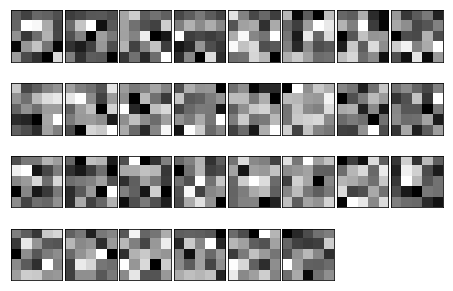

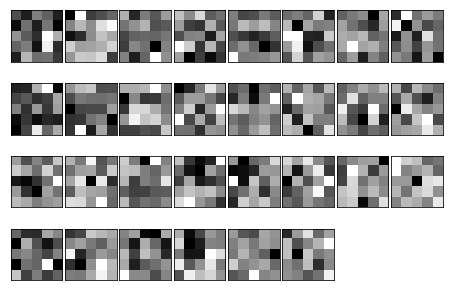

In [47]:
import numpy as np
import matplotlib.pyplot as plt
#from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])


RNN

RNN은 관련 정보와 그 정보를 사용하는 지점 사이 거리가 멀 경우 역전파시 그래디언트가 점차 줄어 학습능력이 크게 저하되는 것으로 알려져 있습니다. 이를 vanishing gradient problem

state 값이 점점 작아지면서 연산을 거듭할수록 0에 가까워짐 0.1x0.1 -> 0.001 ...

-> 보안 LSTM (Long Short-Term Memory): 이전에 계산된 x 값  

이전상태를 언제까지 기억할것인가 

https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/
